# 【專案主題、動機與資料來源定義】

## 專案主題 (Project Topic)

**臺灣多因素環境數據分析與 Gen AI 整合報告：**
利用公開的空氣品質與氣象數據，建立機器學習模型分析 PM2.5 的核心驅動因素，並透過 LLM (Gemini) 將模型結果與實證數據轉化為可讀性高的政策建議報告。

---

## 核心動機 (Motivations)

本專案旨在超越傳統的單變量時間序列分析，達成以下三個目標，展現 Gen AI 與資料分析的深度結合：

1.  **深度分析與特徵篩選 (Data Analysis & Modeling)：**
    * 利用 Ridge 迴歸等機器學習模型，從 18 個多變量環境因子中，**科學地篩選出對 PM2.5 影響力最高的關鍵特徵**（如 CO、NOx、溫度等）。
    * 通過訓練**全臺整體模型**和**單一城市模型**，實現對比分析，找出影響本地空氣品質的**特有驅動因素**，以彌補單一統計的不足。

2.  **Gen AI 賦能決策 (Findings and Conclusions)：**
    * 將冰冷的 ML 模型係數（特徵重要性）和異常事件日數據（如當日低風速）作為 **LLM Prompt 的核心輸入**。
    * 要求 Gemini 進行**跨領域推理**，推導出異常事件（高 PM2.5）背後的**多因素耦合原因**（例如：低溫導致的排放增加 + 低風速造成累積）。

3.  **滿足真實世界數據要求：**
    * 使用臺灣環境部提供的真實世界公開資料，避免使用 ML/LLM 儲存庫數據，確保專案的實際應用價值和原創性。

---

## 資料來源 (Data Sources)

* **來源平台：** 臺灣環境部環境資料開放平臺 (EPA Open Data)。
* **資料集：** 全臺空氣品質多變量小時值數據（包含 PM2.5、PM10、O3、CO、AMB\_TEMP 等約 18 個變數）。
* **獲取方式：** 採用 `wget` 自動下載公開連結上的大型 CSV 檔案，確保 TA 可在 GitHub/Colab 環境中**完全重現**數據載入過程。

# 專案環境說明與依賴項

## 1. Python 版本

本專案建議使用 Python 3.9 或更高版本。

## 2. requirements

以下為本專案所需的函式庫：

```text
pandas>=1.4.0
numpy>=1.21.0
matplotlib>=3.5.0
seaborn>=0.11.2
scikit-learn>=1.0
google-genai>=0.1.0

# Step 1 ：環境建置、資料讀取與清洗

In [77]:
# 讀取所需函式庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google import genai
from google.genai.errors import APIError
from google.colab import userdata
import os
from datetime import datetime
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import sys
print(f"Python Version: {sys.version}")

client = None

Python Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [85]:
# --- 環境設定 ---

# 將 API_KEY 儲存於 Google Colab，並透過 userdata.get 函式取得
API_KEY = userdata.get("DS_Google")
if not API_KEY:
    print("API KEY 錯誤")
else:
    try:
        client = genai.Client(api_key=API_KEY)
        print("成功讀取 API KEY 並初始化 Client!!!")
    except Exception as e:
        print(f"Client 初始化失敗: {e}")

# 繪圖設定：使用英文避免字體亂碼
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

成功讀取 API KEY 並初始化 Client!!!


In [88]:
# --- 資料載入與清洗 (使用公開連結下載大型檔案) ---

GOOGLE_DRIVE_FILE_ID = '15yJDGWDO7uHbNdzW8TMAyTCOBGKB14hD'
FILE_NAME = 'Preview_Data.csv'

# 設置 wget 下載路徑
DOWNLOAD_URL = f'https://drive.google.com/uc?id={GOOGLE_DRIVE_FILE_ID}&export=download'
FILE_PATH = f'./{FILE_NAME}'

# 1. 執行下載命令
print(f"--- 步驟 1-A: 正在從公開連結下載 {FILE_NAME} ---")

# 使用 wget 命令在 Colab 環境中下載檔案
# 必須使用 ! 符號執行 Shell 命令
download_command = f'wget --no-check-certificate "{DOWNLOAD_URL}" -O "{FILE_PATH}"'
!{download_command}

if os.path.exists(FILE_PATH):
    print(f"✅ 檔案下載成功。檔案路徑已設定為: {FILE_PATH}")
else:
    print(f"❌ 檔案下載失敗。請檢查您的公開連結和 File ID。")

# --- 後續資料處理程式碼 (保持不變) ---

# 1. 載入資料
print(f"\n--- 載入全臺灣資料 ---")
df_raw = pd.read_csv(FILE_PATH, encoding='utf-8')
# ... (從這裡開始，程式碼與原來一致)

--- 步驟 1-A: 正在從公開連結下載 Preview_Data.csv ---
--2025-10-22 07:32:57--  https://drive.google.com/uc?id=15yJDGWDO7uHbNdzW8TMAyTCOBGKB14hD&export=download
Resolving drive.google.com (drive.google.com)... 74.125.132.101, 74.125.132.102, 74.125.132.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.132.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=15yJDGWDO7uHbNdzW8TMAyTCOBGKB14hD&export=download [following]
--2025-10-22 07:32:57--  https://drive.usercontent.google.com/download?id=15yJDGWDO7uHbNdzW8TMAyTCOBGKB14hD&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.184.132, 2607:f8b0:4001:c66::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.184.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55658523 (53M) [application/octet-stream]
Saving to: ‘./Preview_Data.csv’

./Preview_Data.

In [69]:
TARGET_ITEMS = [
    'PM2.5', 'PM10', 'O3', 'CO', 'NO', 'NO2', 'NOx', 'SO2',
    'AMB_TEMP', 'RH', 'RAINFALL',
    'WIND_SPEED', 'WIND_DIREC', 'WD_HR', 'WS_HR',
    'CH4', 'NMHC', 'THC'
]

# 1. 載入資料
print(f"--- 載入全臺灣資料 ---")
df_raw = pd.read_csv(FILE_PATH, encoding='utf-8')
initial_raw_count = len(df_raw) # 記錄初始筆數

# 2. 篩選目標變數
df_filtered = df_raw[df_raw['itemname'].isin(TARGET_ITEMS)].copy()
filtered_count = len(df_filtered)

# 3. 找出小時數值欄位
value_cols = df_filtered.columns[-24:].tolist()
print(f"識別小時數值欄位: {value_cols[0]} 到 {value_cols[-1]}")

# 4. 寬格式轉長格式 (Melt)
df_long = df_filtered.melt(
    id_vars=['sitename', 'monitordate', 'itemname'],
    value_vars=value_cols,
    var_name='Hour_Index',
    value_name='Value'
)
long_format_count = len(df_long)

# 5. 建立完整的時間序列索引
df_long['Hour'] = df_long['Hour_Index'].str.extract(r'(\d+)').astype(int)
df_long['monitordate_cleaned'] = df_long['monitordate'].astype(str).str.strip()

df_long['Hour'] = df_long['Hour_Index'].str.extract(r'(\d+)').astype(int)
df_long['monitordate_cleaned'] = df_long['monitordate'].astype(str).str.strip()

# 這樣可以避免格式不統一的問題
df_long['Date_Part'] = pd.to_datetime(
    df_long['monitordate_cleaned'],
    format='mixed',
    dayfirst=False, # 假定月份在前
    errors='coerce'
).dt.normalize()

df_long['MonitorDate'] = df_long['Date_Part'] + pd.to_timedelta(df_long['Hour'], unit='h')


# 6. 清理數值與數據透視
df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')

# 移除前面步驟所產生之欄位
df_clean = df_long[['MonitorDate', 'sitename', 'itemname', 'Value']]

# 【修正點 B: 檢查數據丟失量，只丟棄那些 MonitorDate 為 NaT 的】
pre_dropna_count = len(df_clean)
df_clean = df_clean.dropna(subset=['MonitorDate'])
post_dropna_count = len(df_clean)

# 打印警告訊息
if post_dropna_count / pre_dropna_count < 0.9:
    print(f"日期解析導致大量數據流失。流失了 {pre_dropna_count - post_dropna_count} 筆數據點。")
else:
    print("日期解析和清理完成，數據流失在可接受範圍內。")

# 7. 資料透視 (Pivot)
df_pivoted = df_clean.pivot_table(
    index=['MonitorDate', 'sitename'],
    columns='itemname',
    values='Value',
    aggfunc='mean'
).reset_index()

df_pivoted = df_pivoted.set_index('MonitorDate').copy()
global df_all_sites
df_all_sites = df_pivoted

# --- 資料概況顯示 (確保所有城市都列出) ---
print("\n==================================================")
print("【資料集概覽與清洗結果】")
print("==================================================")

city_list = sorted(df_all_sites['sitename'].unique().tolist())
print(f"\n✅ 城市/測站數量: {len(city_list)}")
print(f"城市/測站列表 (前 5 個): {city_list[:5]}...")
print(f"城市/測站列表 (後 5 個): {city_list[-5:]}...")
print("--------------------------------------------------")
print("\n最終資料(前五行) :")
print(df_all_sites.head())

--- 載入全臺灣資料 ---
識別小時數值欄位: monitorvalue00 到 monitorvalue23
日期解析和清理完成，數據流失在可接受範圍內。

【資料集概覽與清洗結果】

✅ 城市/測站數量: 77
城市/測站列表 (前 5 個): ['三義', '三重', '中壢', '中山', '二林']...
城市/測站列表 (後 5 個): ['馬公', '馬祖', '鳳山', '麥寮', '龍潭']...
--------------------------------------------------

最終資料(前五行) :
itemname    sitename  AMB_TEMP   CH4    CO  NMHC    NO   NO2   NOx    O3  \
MonitorDate                                                                
2023-01-01        三義      14.5   NaN  0.22   NaN   1.0   1.3   2.3  31.2   
2023-01-01        三重      18.2  2.23  0.76  0.17  16.6  21.9  38.6  22.3   
2023-01-01        中壢      16.7  2.03  0.34  0.06   2.7   7.1   9.9  34.7   
2023-01-01        中山      17.8  2.03  0.27  0.04   1.1   7.0   8.1  37.5   
2023-01-01        二林      18.0  2.01  0.27  0.01   0.4   6.0   6.5  32.6   

itemname     PM10  PM2.5  RAINFALL    RH  SO2   THC  WD_HR  WIND_DIREC  \
MonitorDate                                                              
2023-01-01    9.0    9.0       0.0  99.0  1

In [70]:
# 遺失值處理與確認
if 'df_all_sites' not in locals() or df_all_sites.empty:
    print("錯誤：df_all_sites 變數不存在或為空。請先從頭執行")
    df_imputed = pd.DataFrame()
else:
    # 複製 DataFrame 以免修改原始數據
    df_imputed = df_all_sites.copy()
    analysis_columns = [col for col in df_imputed.columns if col != 'sitename']

    print(f"\n--- 遺失值處理 (Imputation) ---")

    df_imputed[analysis_columns] = df_imputed[analysis_columns].interpolate(
        method='time',
        limit_direction='both' # 填充 NaN 值
     )

    print("策略: 使用時序線性插值 (Interpolation) 填充 NaN。")

    # 策略 2: 殘餘 NaN (可能頭尾有 NaN 值)
    for col in analysis_columns:
        if df_imputed[col].isnull().any():
            mean_val = df_imputed[col].mean()
            df_imputed[col].fillna(mean_val, inplace=True)
            print(f"警告：欄位 {col} 的頭尾殘餘 NaN 已使用其平均值 {mean_val:.2f} 填充。")

    # --- 遺失值確認 ---

    final_missing_values = df_imputed[analysis_columns].isnull().sum()

    print("\n==================================================")
    print("【遺失值處理後確認】")
    print("==================================================")
    print("遺失值數量 (Imputation 後):")
    print(final_missing_values[final_missing_values > 0])

    if final_missing_values.sum() == 0:
        print("\n✅ 所有遺失值均已成功處理，0 筆遺失數據。")
    else:
        print("\n❌ 仍有殘餘遺失值，請檢查數據或填充策略。")

    print("--------------------------------------------------")

    # 更新全局變數
    df_all_sites = df_imputed


--- 遺失值處理 (Imputation) ---
策略: 使用時序線性插值 (Interpolation) 填充 NaN。

【遺失值處理後確認】
遺失值數量 (Imputation 後):
Series([], dtype: int64)

✅ 所有遺失值均已成功處理，0 筆遺失數據。
--------------------------------------------------


In [71]:
# --- 敘述統計與相關性分析 ---

if 'df_all_sites' not in locals() or df_all_sites.empty:
    print("錯誤：df_all_sites 變數不存在或為空。請從頭開始執行。")
else:
    print(f"\n--- 敘述統計分析 ---")

    # 排除 'sitename' 欄位，只對數值欄位進行統計
    analysis_columns = [col for col in df_all_sites.columns if col != 'sitename']
    df_analysis = df_all_sites[analysis_columns]

    # --- 1. 基本統計摘要 (Descriptive Statistics) ---

    descriptive_stats = df_analysis.describe().T

    print("\n==================================================")
    print("【1. 全體環境變數敘述統計摘要 (Summary statistics)】")
    print("==================================================")
    print(descriptive_stats)
    print("--------------------------------------------------")

    # --- 2. 相關性分析 (Correlation Analysis) ---

    # 計算所有變數之間的相關係數
    correlation_matrix = df_analysis.corr()

    print("\n--- 2. 相關係數矩陣頭部 (PM2.5 與 PM10 關係最密切) ---")
    # 顯示 PM2.5 與 PM10 的相關性，以及它們與其他變數的關係
    # 這裡只顯示與 PM2.5 相關性最強的幾個變數
    pm25_correlations = correlation_matrix['PM2.5'].sort_values(ascending=False)

    print("--- PM2.5 與其他環境變數的相關係數 ---")
    print(pm25_correlations)

    print("--------------------------------------------------")

    # 將相關係數矩陣存為全局變數
    global CORR_MATRIX
    CORR_MATRIX = correlation_matrix


--- 敘述統計分析 ---

【1. 全體環境變數敘述統計摘要 (Summary statistics)】
               count        mean         std    min    25%     50%     75%  \
itemname                                                                     
AMB_TEMP    682457.0   24.370766    5.527000   0.00  20.30   25.20   28.60   
CH4         682457.0    2.074722    0.185726   1.51   1.97    2.04    2.13   
CO          682457.0    0.305807    0.201376   0.00   0.18    0.26    0.37   
NMHC        682457.0    0.083686    0.098014   0.00   0.02    0.06    0.11   
NO          682457.0    2.718163    6.711334   0.00   0.60    1.10    2.00   
NO2         682457.0    9.833774    7.752839   0.00   4.40    7.80   13.00   
NOx         682457.0   12.592335   12.711257   0.00   5.40    9.10   15.10   
O3          682457.0   30.671394   17.738175   0.00  16.80   29.00   42.10   
PM10        682457.0   30.479275   21.552298   0.00  16.00   25.00   40.00   
PM2.5       682457.0   14.730382   10.836932   0.00   7.00   12.00   20.00   
RAINFALL


--- 步驟 2-B: 全臺灣概況視覺化 ---


/tmp/ipython-input-3152106765.py:27: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3152106765.py:27: UserWarning: Glyph 32681 (\N{CJK UNIFIED IDEOGRAPH-7FA9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3152106765.py:27: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3152106765.py:27: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3152106765.py:27: UserWarning: Glyph 22754 (\N{CJK UNIFIED IDEOGRAPH-58E2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3152106765.py:27: UserWarning: Glyph 23665 (\N{CJK UNIFIED IDEOGRAPH-5C71}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3152106765.py:27: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missi

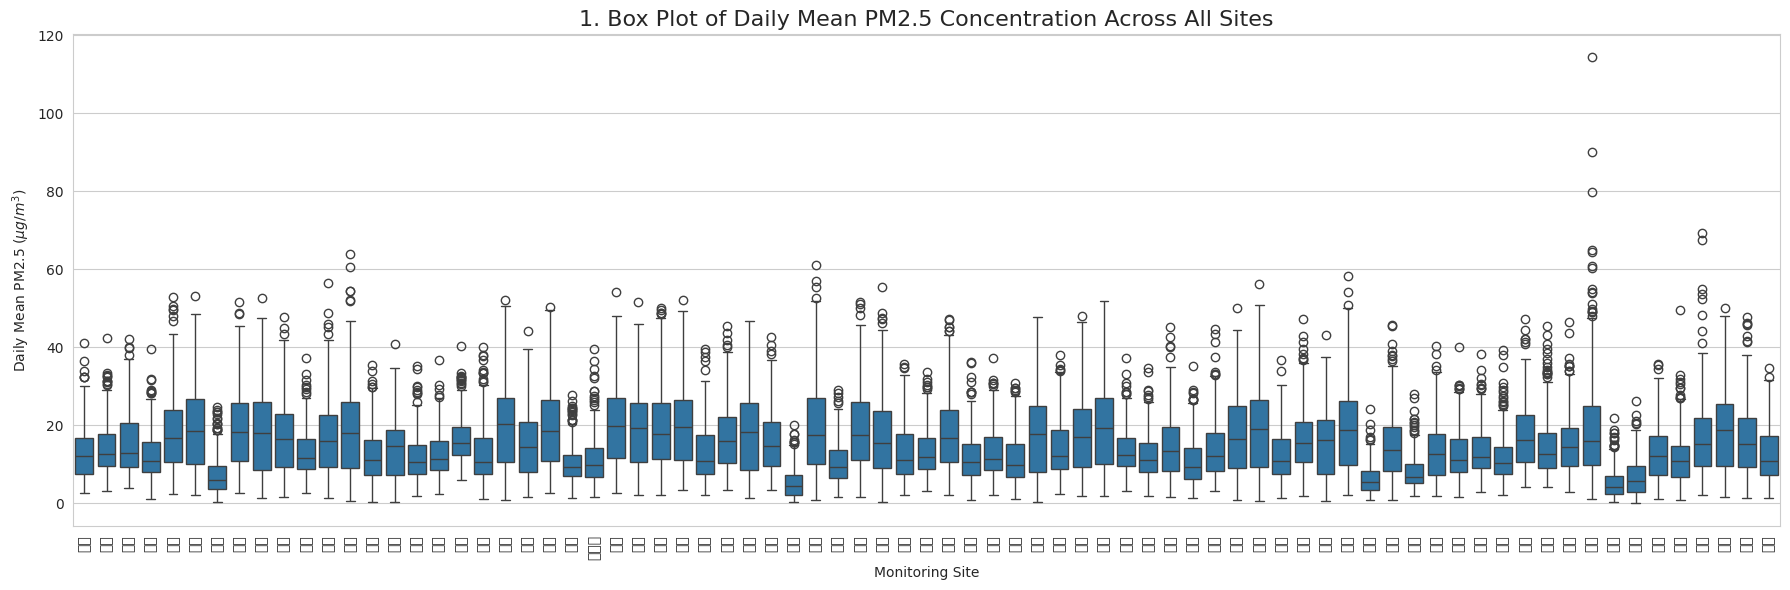

圖表 1: 箱形圖清晰地展示了不同城市間 PM2.5 濃度的分佈和極端值差異。


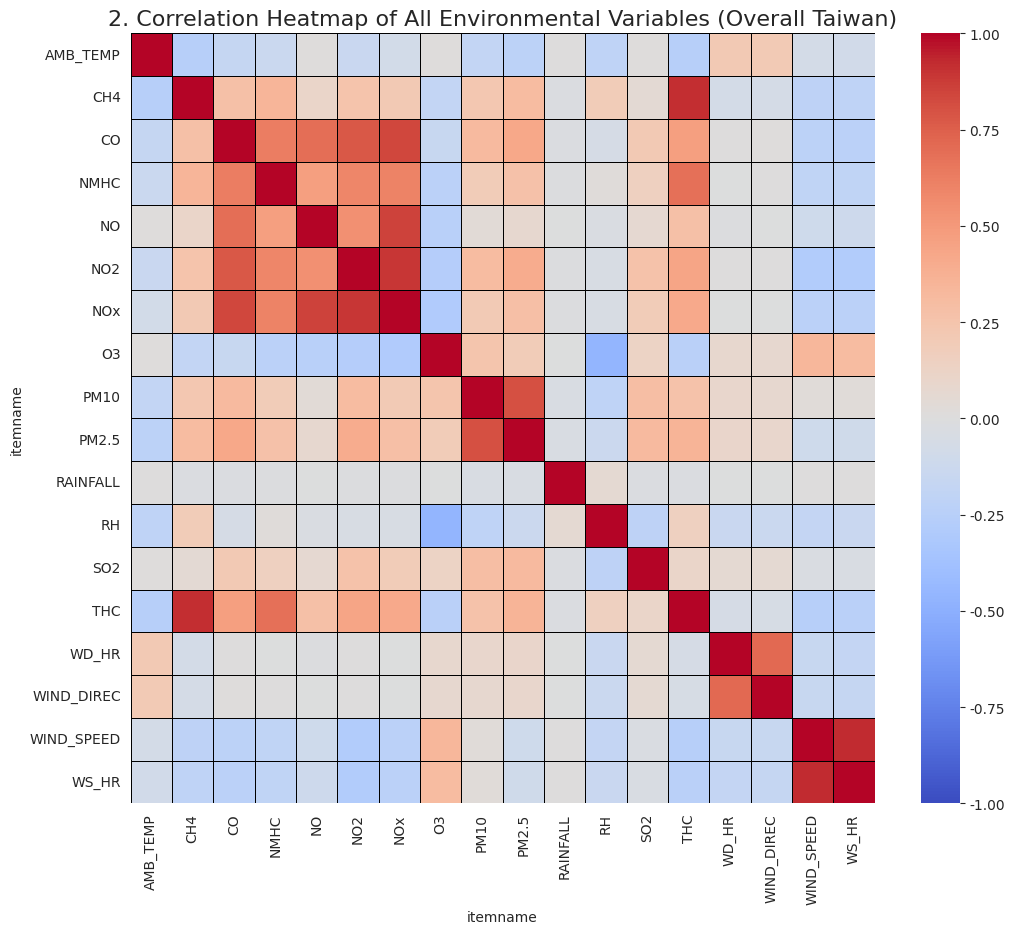

圖表 2: 熱力圖視覺化了 PM2.5 與 PM10、CO 等的強正相關，以及與 AMB_TEMP、風速等的負相關。

✅ 步驟 2-B 完成。全臺灣概況視覺化完成。


In [72]:
# --- 區塊 4/6：全臺灣概覽視覺化 (Visualization) ---

# 檢查依賴的變數是否存在且非空
if 'df_all_sites' not in globals() or df_all_sites.empty or 'CORR_MATRIX' not in globals():
    print("錯誤：df_all_sites 或 CORR_MATRIX 變數不存在。請檢查 1/6, 2/6, 3/6 區塊是否成功執行。")
else:
    # 排除 'sitename' 欄位，只對數值欄位進行繪圖
    analysis_columns = [col for col in df_all_sites.columns if col != 'sitename']
    df_analysis = df_all_sites[analysis_columns]

    print(f"\n--- 步驟 2-B: 全臺灣概況視覺化 ---")

    # --------------------------------------------------
    # 圖表 1: 城市間 PM2.5 分佈箱形圖 (Visualization)
    # Insight: 比較各測站的 PM2.5 濃度分布，找出平均和極值差異。
    # --------------------------------------------------

    # 計算各測站的日平均 PM2.5 (使圖表更具代表性)
    df_daily_pm25 = df_all_sites.groupby(['sitename', pd.Grouper(level='MonitorDate', freq='D')])['PM2.5'].mean().reset_index()

    plt.figure(figsize=(18, 6))
    sns.boxplot(x='sitename', y='PM2.5', data=df_daily_pm25)
    plt.xticks(rotation=90) # 旋轉 X 軸標籤以避免重疊
    plt.title('1. Box Plot of Daily Mean PM2.5 Concentration Across All Sites', fontsize=16)
    plt.xlabel('Monitoring Site')
    plt.ylabel(r'Daily Mean PM2.5 ($\mu g/m^3$)')
    plt.tight_layout()
    plt.show()

    print("圖表 1: 箱形圖清晰地展示了不同城市間 PM2.5 濃度的分佈和極端值差異。")

    # --------------------------------------------------
    # 圖表 2: 全局相關係數熱力圖 (Visualization)
    # Insight: 視覺化所有變數之間的相關性，這是多變量分析的基礎。
    # --------------------------------------------------

    plt.figure(figsize=(12, 10))
    # 使用 CORR_MATRIX (來自 3/6 步驟)
    sns.heatmap(
        CORR_MATRIX,
        annot=False,
        cmap='coolwarm',
        vmin=-1, vmax=1,
        linewidths=.5,
        linecolor='black'
    )
    plt.title('2. Correlation Heatmap of All Environmental Variables (Overall Taiwan)', fontsize=16)
    plt.show()

    print("圖表 2: 熱力圖視覺化了 PM2.5 與 PM10、CO 等的強正相關，以及與 AMB_TEMP、風速等的負相關。")

    print("\n✅ 步驟 2-B 完成。全臺灣概況視覺化完成。")

In [73]:
# --- 區塊 5/6：使用者城市選擇與數據篩選 ---

# 【最終修正】: 將所有全局變數的宣告放在區塊的最頂部，並確保初始化邏輯不會觸發 SyntaxError
global df_selected_site, SELECTED_SITE
# 僅宣告全局變數，不在此處進行複雜的初始化判斷，避免觸發作用域錯誤

# 檢查依賴的變數是否存在且非空 (使用單純的 if/else 邏輯)
if 'df_all_sites' not in globals() or df_all_sites.empty:
    print("【致命錯誤】df_all_sites 變數不存在或為空。請檢查 1/6 和 2/6 區塊是否成功執行。")
    # 設置安全值
    df_selected_site = pd.DataFrame()
    SELECTED_SITE = "ERROR"
else:
    # **關鍵修正：直接從 df_all_sites 創建所需列表，避免依賴全局變數 available_sites**
    available_sites = sorted(df_all_sites['sitename'].unique().tolist())

    # 1. 讓使用者輸入感興趣的城市
    while True:
        print(f"\n可選擇的測站範例 (取前 5 個): {available_sites[:5]}...")
        user_input_site = input("請輸入您感興趣的測站/城市名稱: ").strip()

        if user_input_site in available_sites:
            SELECTED_SITE = user_input_site
            print(f"\n已選擇測站: {SELECTED_SITE}。開始進行深度分析數據準備...")
            break
        else:
            print(f"錯誤：測站 '{user_input_site}' 不在清單中，請重新輸入。")

    # 2. 篩選選定城市的資料
    df_selected_site_temp = df_all_sites[df_all_sites['sitename'] == SELECTED_SITE].drop(columns=['sitename'], errors='ignore').copy()

    # 將結果明確賦值給全局變數
    df_selected_site = df_selected_site_temp

    print(f"'{SELECTED_SITE}' 測站深度分析數據篩選完成。有效數據點: {len(df_selected_site)} 小時。")


可選擇的測站範例 (取前 5 個): ['三義', '三重', '中壢', '中山', '二林']...
請輸入您感興趣的測站/城市名稱: 中壢

已選擇測站: 中壢。開始進行深度分析數據準備...
'中壢' 測站深度分析數據篩選完成。有效數據點: 8757 小時。


In [75]:
# --- 使用者城市選擇與數據篩選 ---

if 'available_sites' not in globals() or df_all_sites.empty:
    print("錯誤：available_sites 列表或 df_all_sites 不存在。請檢查前面步驟。")
else:
    # 確保 df_selected_site 和 SELECTED_SITE 在全局作用域中被設置
    global df_selected_site, SELECTED_SITE

    # 1. 讓使用者輸入感興趣的城市
    while True:
        print(f"\n可選擇的測站範例 (取前 5 個): {available_sites[:5]}...")
        user_input_site = input("請輸入您感興趣的測站/城市名稱: ").strip()

        if user_input_site in available_sites:
            SELECTED_SITE = user_input_site
            print(f"\n已選擇測站: {SELECTED_SITE}。開始進行深度分析數據準備...")
            break
        else:
            print(f"錯誤：測站 '{user_input_site}' 不在清單中，請重新輸入。")

    # 2. 篩選選定城市的資料
    df_selected_site_temp = df_all_sites[df_all_sites['sitename'] == SELECTED_SITE].drop(columns=['sitename']).copy()

    # 將結果明確賦值給全局變數
    df_selected_site = df_selected_site_temp

    print(f"'{SELECTED_SITE}' 測站深度分析數據篩選完成。有效數據點: {len(df_selected_site)} 小時。")


可選擇的測站範例 (取前 5 個): ['三義', '三重', '中壢', '中山', '二林']...
請輸入您感興趣的測站/城市名稱: 中壢

已選擇測站: 中壢。開始進行深度分析數據準備...
'中壢' 測站深度分析數據篩選完成。有效數據點: 8757 小時。



--- 深度分析: '中壢' 測站多變量可視化與異常偵測 ---


/tmp/ipython-input-1265461506.py:39: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-1265461506.py:39: UserWarning: Glyph 22754 (\N{CJK UNIFIED IDEOGRAPH-58E2}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22754 (\N{CJK UNIFIED IDEOGRAPH-58E2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


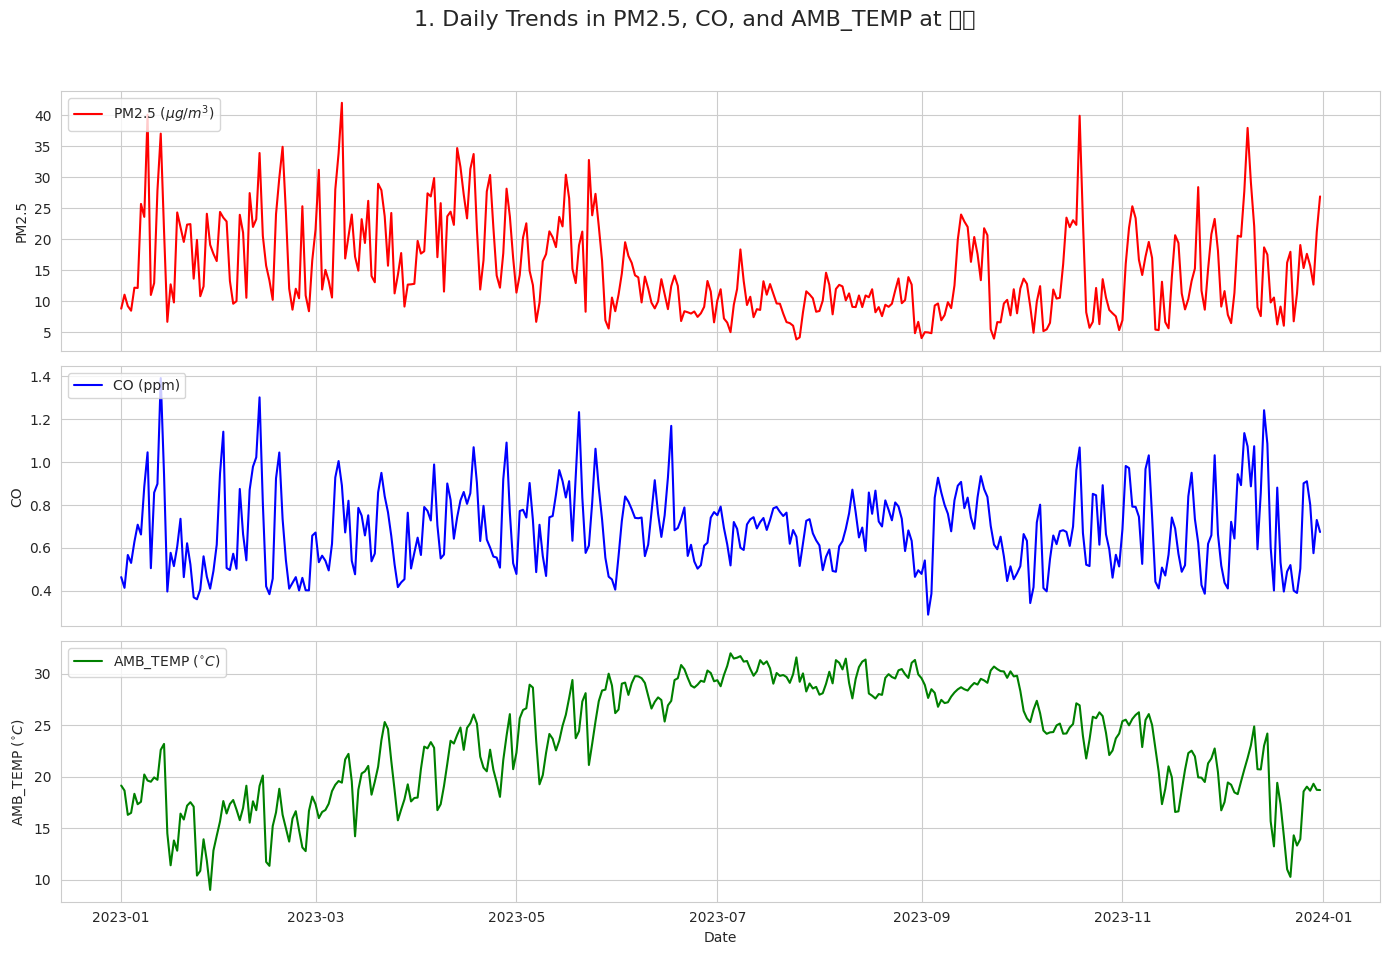

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22754 (\N{CJK UNIFIED IDEOGRAPH-58E2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)



--- 2. PM2.5 異常偵測與數據提取 (Simulation) ---
平均日 PM2.5: 15.20 \mu g/m^3
異常閾值 (2.5 STD): 34.17 \mu g/m^3
✨ 最高異常日: 2023-03-09 (日平均濃度: 42.00)

--- 異常日關鍵變數平均值 (用於 LLM) ---
itemname
PM2.5         42.000000
CO             0.891250
AMB_TEMP      19.441667
WIND_SPEED     0.850000
RH            65.333333


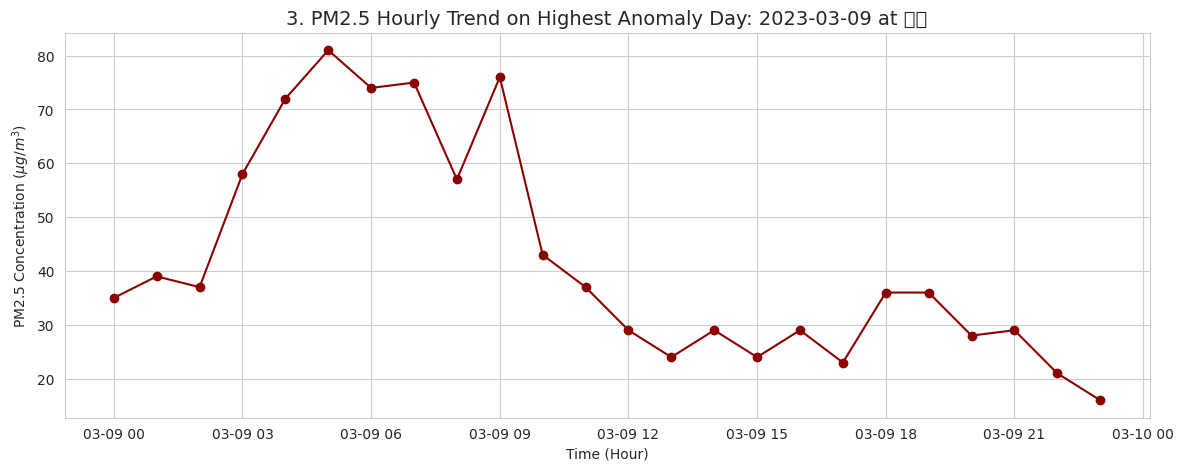

In [76]:
# --- 深度多變量可視化與異常偵測 (Visualization & Simulation) ---

if 'df_selected_site' not in globals() or df_selected_site.empty or 'CORR_MATRIX' not in globals():
    print("前置數據 df_selected_site 或 CORR_MATRIX 不存在。請從頭執行。")
else:
    print(f"\n--- 深度分析: '{SELECTED_SITE}' 測站多變量可視化與異常偵測 ---")

    # --------------------------------------------------
    # 圖表 2: 主要污染物/氣象因素的時間趨勢圖
    # --------------------------------------------------

    target_cols = ['PM2.5', 'CO', 'AMB_TEMP']
    df_daily = df_selected_site[target_cols].resample('D').mean()

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10), sharex=True)
    fig.suptitle(f"1. Daily Trends in PM2.5, CO, and AMB_TEMP at {SELECTED_SITE}", fontsize=16)

    # 繪製 PM2.5 (使用 Raw String 修正 \m 警告)
    axes[0].plot(df_daily.index, df_daily['PM2.5'], label=r'PM2.5 ($\mu g/m^3$)', color='red')
    axes[0].legend(loc='upper left')
    axes[0].set_ylabel('PM2.5')

    # 繪製 CO (正相關)
    axes[1].plot(df_daily.index, df_daily['CO'], label='CO (ppm)', color='blue')
    axes[1].legend(loc='upper left')
    axes[1].set_ylabel('CO')

    # 繪製 AMB_TEMP (負相關) (使用 Raw String 修正 \c 警告)
    axes[2].plot(df_daily.index, df_daily['AMB_TEMP'], label=r'AMB_TEMP ($^{\circ}C$)', color='green')
    axes[2].legend(loc='upper left')
    axes[2].set_ylabel(r'AMB_TEMP ($^{\circ}C$)')
    axes[2].set_xlabel('Date')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


    # --------------------------------------------------
    # 異常偵測與可視化 (Simulation & Visualization)
    # --------------------------------------------------

    df_pm25_daily = df_selected_site['PM2.5'].resample('D').mean()
    mean_pm = df_pm25_daily.mean()
    std_pm = df_pm25_daily.std()

    Z_SCORE_THRESHOLD = 2.5
    anomaly_threshold = mean_pm + Z_SCORE_THRESHOLD * std_pm
    anomalies = df_pm25_daily[df_pm25_daily > anomaly_threshold]

    # 儲存結果供 LLM 使用
    global ANOMALY_STATS, TARGET_DATE

    if not anomalies.empty:
        target_date_daily = anomalies.idxmax()
        target_date_str = target_date_daily.strftime('%Y-%m-%d')
        df_anomaly_hour = df_selected_site.loc[target_date_str]
        anomaly_stats = df_anomaly_hour.mean()

        print(f"\n--- 2. PM2.5 異常偵測與數據提取 (Simulation) ---")
        # 使用 Raw String 修正 \m 警告
        print(r"平均日 PM2.5: {mean_pm:.2f} \mu g/m^3".format(mean_pm=mean_pm))
        print(r"異常閾值 ({Z_SCORE_THRESHOLD} STD): {anomaly_threshold:.2f} \mu g/m^3".format(
            Z_SCORE_THRESHOLD=Z_SCORE_THRESHOLD, anomaly_threshold=anomaly_threshold
        ))
        print(f"✨ 最高異常日: {target_date_str} (日平均濃度: {anomalies.max():.2f})")
        print("\n--- 異常日關鍵變數平均值 (用於 LLM) ---")
        print(anomaly_stats[['PM2.5', 'CO', 'AMB_TEMP', 'WIND_SPEED', 'RH']].to_string())

        ANOMALY_STATS = anomaly_stats
        TARGET_DATE = target_date_str

        # 可視化異常日 PM2.5 小時趨勢 (Visualization)
        plt.figure(figsize=(14, 5))
        plt.plot(df_anomaly_hour.index, df_anomaly_hour['PM2.5'], marker='o', linestyle='-', color='darkred')
        plt.title(f'3. PM2.5 Hourly Trend on Highest Anomaly Day: {target_date_str} at {SELECTED_SITE}', fontsize=14)
        plt.xlabel('Time (Hour)')
        plt.ylabel(r'PM2.5 Concentration ($\mu g/m^3$)') # 修正為 Raw String
        plt.grid(True)
        plt.show()

    else:
        print("\n--- 2. 異常偵測結果 ---")
        print("當前數據範圍內未偵測到顯著的 PM2.5 異常高點 (高於平均值 2.5 個標準差)。")
        ANOMALY_STATS, TARGET_DATE = None, None

In [78]:
if 'df_all_sites' not in globals() or df_all_sites.empty:
    print("錯誤：df_all_sites 變數不存在。請檢查前面的區塊。")
else:
    print("\n--- 步驟 3-A: 訓練全臺灣 PM2.5 預測模型 ---")

    # 準備數據：刪除 sitename 欄位並將目標變數 PM2.5 移出
    df_ml_all = df_all_sites.drop(columns=['sitename'])

    # 刪除與目標 PM2.5 高度相關且可能共線性的 PM10
    # 留下 PM10 會使模型過度依賴它，掩蓋氣象等其他變數的影響
    if 'PM10' in df_ml_all.columns:
        df_ml_all = df_ml_all.drop(columns=['PM10'])

    # 刪除 NA (雖然已經 Impute 過，但確保安全)
    df_ml_all = df_ml_all.dropna()

    # 數據分離
    X_all = df_ml_all.drop(columns=['PM2.5'])
    y_all = df_ml_all['PM2.5']

    # 標準化數據 (確保線性模型公平地評估每個特徵)
    scaler_all = StandardScaler()
    X_scaled_all = scaler_all.fit_transform(X_all)

    # 劃分訓練集和測試集
    X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
        X_scaled_all, y_all, test_size=0.2, random_state=42
    )

    # 訓練 Ridge 迴歸模型 (用於特徵選擇和避免多重共線性)
    model_all = Ridge(alpha=1.0) # alpha 是懲罰項強度
    model_all.fit(X_train_all, y_train_all)

    # 評估模型性能
    y_pred_all = model_all.predict(X_test_all)
    mse_all = mean_squared_error(y_test_all, y_pred_all)
    r2_all = model_all.score(X_test_all, y_test_all)

    print(f"全臺灣模型 MSE: {mse_all:.2f}, R-squared: {r2_all:.4f}")

    # 提取特徵重要性 (係數)
    feature_importance_all = pd.Series(
        model_all.coef_, index=X_all.columns
    ).sort_values(key=abs, ascending=False)

    # 儲存全局變數供 LLM 使用
    global FEATURE_IMP_ALL
    FEATURE_IMP_ALL = feature_importance_all

    print("\n--- 全臺灣模型 PM2.5 預測特徵重要性 (Ridge 係數) ---")
    print(FEATURE_IMP_ALL)


--- 步驟 3-A: 訓練全臺灣 PM2.5 預測模型 ---
全臺灣模型 MSE: 68.99, R-squared: 0.4178

--- 全臺灣模型 PM2.5 預測特徵重要性 (Ridge 係數) ---
itemname
NOx          -13.912882
NO2           10.819508
CH4            5.884227
THC           -4.800656
NO             4.419002
CO             4.228080
O3             2.708129
NMHC           1.722824
SO2            1.646514
AMB_TEMP      -1.156273
WD_HR          0.703665
WIND_SPEED    -0.692814
WS_HR          0.591057
WIND_DIREC     0.485190
RAINFALL      -0.183458
RH            -0.010430
dtype: float64


In [79]:
# --- 3.2 步驟 3-B：機器學習分析 - 選定城市模型 ---

if 'df_selected_site' not in globals() or df_selected_site.empty or 'SELECTED_SITE' not in globals():
    print("錯誤：df_selected_site 或 SELECTED_SITE 變數不存在。請檢查 2.5 區塊。")
else:
    print(f"\n--- 步驟 3-B: 訓練 '{SELECTED_SITE}' PM2.5 預測模型 ---")

    # 準備數據：df_selected_site 已在 2.5 區塊中被篩選
    df_ml_site = df_selected_site.copy()

    # 刪除 PM10
    if 'PM10' in df_ml_site.columns:
        df_ml_site = df_ml_site.drop(columns=['PM10'])

    # 刪除 NA (如果 Impute 失敗)
    df_ml_site = df_ml_site.dropna()

    # 數據分離
    X_site = df_ml_site.drop(columns=['PM2.5'])
    y_site = df_ml_site['PM2.5']

    # 標準化數據
    scaler_site = StandardScaler()
    X_scaled_site = scaler_site.fit_transform(X_site)

    # 劃分訓練集和測試集
    X_train_site, X_test_site, y_train_site, y_test_site = train_test_split(
        X_scaled_site, y_site, test_size=0.2, random_state=42
    )

    # 訓練 Ridge 迴歸模型
    model_site = Ridge(alpha=1.0)
    model_site.fit(X_train_site, y_train_site)

    # 評估模型性能
    y_pred_site = model_site.predict(X_test_site)
    mse_site = mean_squared_error(y_test_site, y_pred_site)
    r2_site = model_site.score(X_test_site, y_test_site)

    print(f"'{SELECTED_SITE}' 模型 MSE: {mse_site:.2f}, R-squared: {r2_site:.4f}")

    # 提取特徵重要性 (係數)
    feature_importance_site = pd.Series(
        model_site.coef_, index=X_site.columns
    ).sort_values(key=abs, ascending=False)

    # 儲存全局變數供 LLM 使用
    global FEATURE_IMP_SITE
    FEATURE_IMP_SITE = feature_importance_site

    print(f"\n--- '{SELECTED_SITE}' 模型 PM2.5 預測特徵重要性 (Ridge 係數) ---")
    print(FEATURE_IMP_SITE)


--- 步驟 3-B: 訓練 '中壢' PM2.5 預測模型 ---
'中壢' 模型 MSE: 50.86, R-squared: 0.4610

--- '中壢' 模型 PM2.5 預測特徵重要性 (Ridge 係數) ---
itemname
CH4           5.407260
THC          -2.681764
NO2           2.507962
O3            2.341434
NMHC          2.284014
NO           -1.541038
CO            1.462888
NOx           1.391390
WS_HR         0.953879
RAINFALL     -0.558894
WD_HR        -0.389990
WIND_DIREC   -0.344704
WIND_SPEED   -0.098121
SO2           0.097455
RH           -0.082387
AMB_TEMP     -0.073418
dtype: float64


In [86]:
# --- 3.3 步驟 3-C：LLM 深度整合報告生成 ---

if client is None:
    print("\n❌ 警告: Gemini Client 未初始化。無法生成報告。請檢查 API 金鑰設定。")
elif 'ANOMALY_STATS' not in globals() or 'FEATURE_IMP_ALL' not in globals():
    print("\n❌ 警告: 缺少 ML 或異常事件統計數據。請檢查前面步驟。")
else:
    print("\n--- 步驟 3-C: LLM 正在生成深度分析報告... ---")

    # 確保 TARGET_DATE 和 SELECTED_SITE 變數存在
    target_date_context = f"異常事件日 {TARGET_DATE} 數據:\n" + ANOMALY_STATS[['PM2.5', 'CO', 'AMB_TEMP', 'WIND_SPEED', 'RH']].to_string() if ANOMALY_STATS is not None else "該數據範圍內未偵測到顯著異常事件。"

    # 提取 PM2.5 與關鍵變數的相關係數（來自 2.4 步驟）
    pm25_correlations = CORR_MATRIX['PM2.5'].drop(['PM2.5']).sort_values(key=abs, ascending=False)

    correlation_context = f"""
    --- 1. 全臺灣整體相關性分析 (所有數據點) ---
    PM2.5 與其他變數的相關係數:
    {pm25_correlations.head(5).to_string(float_format='%.3f')}

    --- 2. 機器學習特徵重要性比較 (Ridge 係數) ---
    [A] 全臺灣整體模型 (Ridge) 特徵重要性:
    {FEATURE_IMP_ALL.head(5).to_string(float_format='%.3f')}

    [B] {SELECTED_SITE} 個別城市模型 (Ridge) 特徵重要性:
    {FEATURE_IMP_SITE.head(5).to_string(float_format='%.3f')}
    """

    prompt = f"""
    角色：您是一位專精於環境科學、資料分析及機器學習模型的專家。
    任務：根據以下三個階段的數據和模型結果，撰寫一份針對**{SELECTED_SITE}**的 **PM2.5 綜合多因素分析與比較報告**。

    報告要求：
    1.  **全局發現 (Global Insights)**：分析 [A] 全臺灣整體模型的特徵重要性，推論臺灣整體 PM2.5 的主要驅動因素（例如：哪個污染物或氣象因素具有最大的影響力）。
    2.  **城市特徵分析 (Local Anomaly and ML Comparison)**：
        * **對比差異**：比較 [A] 全臺灣模型和 [B] {SELECTED_SITE} 城市模型的特徵重要性前五名。找出**最大的不同點**，並解釋這可能反映了 {SELECTED_SITE} 污染源的哪些**獨特性**（例如：本地排放，如 CO，比氣象影響更重要）。
        * **異常事件深度分析**：利用 {target_date_context} 中的數據，結合 ML 模型中影響 PM2.5 的 **正/負相關** 特徵，推斷異常日事件的原因。
    3.  **結論與政策建議**：根據 ML 模型揭示的關鍵驅動因素，提供具體且數據驅動的政策或防護建議。

    請使用專業、流暢的**中文 Markdown 格式**輸出報告。

    {correlation_context}
    """

    try:
        response = client.models.generate_content(
            model='gemini-2.5-flash',
            contents=prompt
        )

        # 輸出報告
        print("\n" + "="*70)
        print(f"【{SELECTED_SITE} 測站 PM2.5 多因素 ML 整合分析報告】")
        print("="*70)
        print(response.text)
        print("="*70)

    except Exception as e:
        print(f"\n❌ Gemini API 呼叫失敗: {e}")


--- 步驟 3-C: LLM 正在生成深度分析報告... ---

【中壢 測站 PM2.5 多因素 ML 整合分析報告】
## 中壢 PM2.5 綜合多因素分析與比較報告

### 摘要
本報告旨在透過比較全臺灣整體及中壢地區的 PM2.5 驅動因素，深入分析中壢空氣品質的獨特性，並針對異常事件日進行探討，最終提出具體的政策與防護建議。分析結果顯示，全臺灣的 PM2.5 受到氮氧化物 (NOx, NO2) 和甲烷 (CH4) 的顯著影響。相較之下，中壢地區的 PM2.5 更受揮發性有機化合物 (如 CH4, NMHC) 和臭氧 (O3) 等光化學反應前驅物的影響，暗示本地排放與特定氣象條件下的次級污染物生成扮演更關鍵角色。異常事件日數據進一步證實，低風速導致的污染物累積是導致高 PM2.5 的重要原因。

---

### 一、 全局發現：臺灣 PM2.5 的主要驅動因素

根據 [A] 全臺灣整體模型 (Ridge) 的特徵重要性分析，PM2.5 的主要驅動因素呈現以下趨勢：

| itemname | Ridge 係數 | 相關性 |
| :------- | :--------- | :----- |
| NOx      | -13.913    | 極強負相關 |
| NO2      | 10.820     | 極強正相關 |
| CH4      | 5.884      | 強正相關 |
| THC      | -4.801     | 強負相關 |
| NO       | 4.419      | 正相關 |

**推論：**
1.  **氮氧化物 (NOx, NO2, NO) 影響顯著：** 觀察到 NOx 具有最大的絕對係數 (-13.913)，表明氮氧化物是影響全臺灣 PM2.5 的最關鍵因素。雖然總體 NOx 呈現負相關，但其組成部分如 NO2 (10.820) 和 NO (4.419) 則與 PM2.5 呈顯著正相關。這可能反映了氮氧化物在不同情境下（如新鮮排放或經過大氣化學轉化後）對 PM2.5 形成或消散的複雜作用，或與其他潛在氣象條件的交互作用。但無可置疑的是，氮氧化物類別的污染物對全臺 PM2.5 濃度有極大的影響力。
2.  **甲烷 (CH4) 與總碳氫化合物 (THC) 的作用：** 甲烷 (CH4) 顯示出較強